# Dataset MNIST
Os dígitos manuscritos no conjunto de dados MNIST são imagens de escala de cinza de 28x28 pixels. Para este tutorial vamos utilizar as 60K imagens para treino e 10K para teste.

 
Cada "neurônio" em uma rede neural possui uma soma ponderada de todas as suas entradas, adiciona uma constante chamada "polarização" e, em seguida, alimenta o resultado através de alguma função de ativação não-linear.
![alt text](https://i.stack.imgur.com/E6SsE.png)

A abordagem mais simples para classificá-los é usar os 28x28 = 784 pixels como entradas para uma rede neural de 1 camada.
Aqui, nós criamos uma rede neural de 1 camada com 10 neurônios de saída, pois queremos classificar os dígitos em 10 aulas (0 a 9):
![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/d5222c6e3d15770a.png)

Para um problema de classificação, uma função de ativação que funciona bem é softmax. Aplicar softmax em um vetor é feito tomando a exponencial de cada elemento e depois normalizando o vetor (usando qualquer norma, por exemplo, o comprimento euclidiano normal do vetor).

In [2]:

import tensorflow as tf
import tensorflowvisu
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   # 784 = 28*28
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1 [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2 [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3 [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4 [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y5 [batch, 10]

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)



Tensorflow version 1.1.0
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


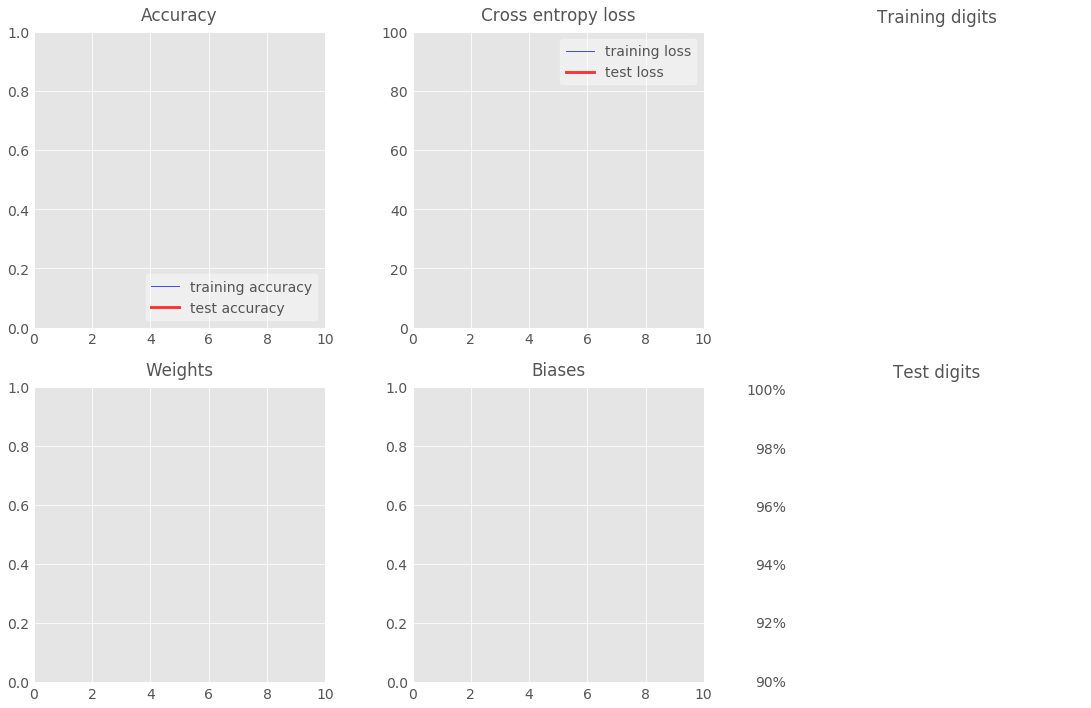

max test accuracy: 0


In [3]:
# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])

# five layers and their number of neurons (tha last layer has 10 softmax neurons)
L = 200
M = 100
N = 60
O = 30
# Weights initialised with small random values between -0.2 and +0.2
# When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([L]))
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.zeros([M]))
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.zeros([N]))
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.zeros([O]))
W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

# The model
XX = tf.reshape(X, [-1, 784])
Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1)
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# matplotlib visualisation
allweights = tf.concat([tf.reshape(W1, [-1]), tf.reshape(W2, [-1]), tf.reshape(W3, [-1]), tf.reshape(W4, [-1]), tf.reshape(W5, [-1])], 0)
allbiases  = tf.concat([tf.reshape(B1, [-1]), tf.reshape(B2, [-1]), tf.reshape(B3, [-1]), tf.reshape(B4, [-1]), tf.reshape(B5, [-1])], 0)
I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)
It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)
datavis = tensorflowvisu.MnistDataVis()

# training step, learning rate = 0.003
learning_rate = 0.003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values for visualisation
    if update_train_data:
        a, c, im, w, b = sess.run([accuracy, cross_entropy, I, allweights, allbiases], {X: batch_X, Y_: batch_Y})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        datavis.append_training_curves_data(i, a, c)
        datavis.update_image1(im)
        datavis.append_data_histograms(i, w, b)

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], {X: mnist.test.images, Y_: mnist.test.labels})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y})

datavis.animate(training_step, iterations=10000+1, train_data_update_freq=20, test_data_update_freq=100, more_tests_at_start=True)

# to save the animation as a movie, add save_movie=True as an argument to datavis.animate
# to disable the visualisation use the following line instead of the datavis.animate line
# for i in range(10000+1): training_step(i, i % 100 == 0, i % 20 == 0)

print("max test accuracy: " + str(datavis.get_max_test_accuracy()))

# Some results to expect:
# (In all runs, if sigmoids are used, all biases are initialised at 0, if RELUs are used,
# all biases are initialised at 0.1 apart from the last one which is initialised at 0.)

## learning rate = 0.003, 10K iterations
# final test accuracy = 0.9788 (sigmoid - slow start, training cross-entropy not stabilised in the end)
# final test accuracy = 0.9825 (relu - above 0.97 in the first 1500 iterations but noisy curves)

## now with learning rate = 0.0001, 10K iterations
# final test accuracy = 0.9722 (relu - slow but smooth curve, would have gone higher in 20K iterations)

## decaying learning rate from 0.003 to 0.0001 decay_speed 2000, 10K iterations
# final test accuracy = 0.9746 (sigmoid - training cross-entropy not stabilised)
# final test accuracy = 0.9824 (relu - training set fully learned, test accuracy stable)


In [4]:
datavis.animate(training_step, iterations=10000+1, train_data_update_freq=20, test_data_update_freq=100, more_tests_at_start=True)

In [5]:
for i in range(10000+1): training_step(i, i % 100 == 0, i % 20 == 0)

0: accuracy:0.11 loss: 230.504 (lr:0.003)
0: ********* epoch 1 ********* test accuracy:0.0958 test loss: 232.891
20: accuracy:0.07 loss: 228.801 (lr:0.003)
40: accuracy:0.14 loss: 216.825 (lr:0.003)
60: accuracy:0.33 loss: 184.551 (lr:0.003)
80: accuracy:0.58 loss: 157.174 (lr:0.003)
100: accuracy:0.54 loss: 138.855 (lr:0.003)
100: ********* epoch 1 ********* test accuracy:0.539 test loss: 143.565
120: accuracy:0.56 loss: 126.425 (lr:0.003)
140: accuracy:0.74 loss: 106.944 (lr:0.003)
160: accuracy:0.67 loss: 111.782 (lr:0.003)
180: accuracy:0.79 loss: 81.2805 (lr:0.003)
200: accuracy:0.81 loss: 69.9258 (lr:0.003)
200: ********* epoch 1 ********* test accuracy:0.8138 test loss: 75.831
220: accuracy:0.82 loss: 56.7935 (lr:0.003)
240: accuracy:0.87 loss: 61.4181 (lr:0.003)
260: accuracy:0.91 loss: 57.5063 (lr:0.003)
280: accuracy:0.85 loss: 55.0471 (lr:0.003)
300: accuracy:0.87 loss: 48.0984 (lr:0.003)
300: ********* epoch 1 ********* test accuracy:0.9035 test loss: 42.4744
320: accuracy: